## Import

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Split data
from sklearn.model_selection import train_test_split

## Functions

In [2]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Values")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

In [3]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [4]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  
  return {
    "mae": mae.numpy(),
    "mape": mape.numpy(),
    "mase": mase.numpy(),
    "mse": mse.numpy(),
    "rmse": rmse.numpy()
  }

In [5]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [6]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [7]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [8]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

## Download the Bitcoin data

In [9]:
url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv'

bitcoin_csv = tf.keras.utils.get_file(origin=url)
bitcoin_csv

'C:\\Users\\bruce\\.keras\\datasets\\BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv'

In [10]:
df = pd.read_csv(
    bitcoin_csv,
    parse_dates=['Date'],
    index_col=['Date'] # pass the column 1 and tell pandas column 1 is a datatime
)
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [12]:
print(f'There are {len(df)} samples')

There are 2787 samples


## Preview the data

In [13]:
bitcoin_prices_df = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices_df

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


In [14]:
timesteps = bitcoin_prices_df.index.to_numpy()
prices = bitcoin_prices_df['Price'].to_numpy()

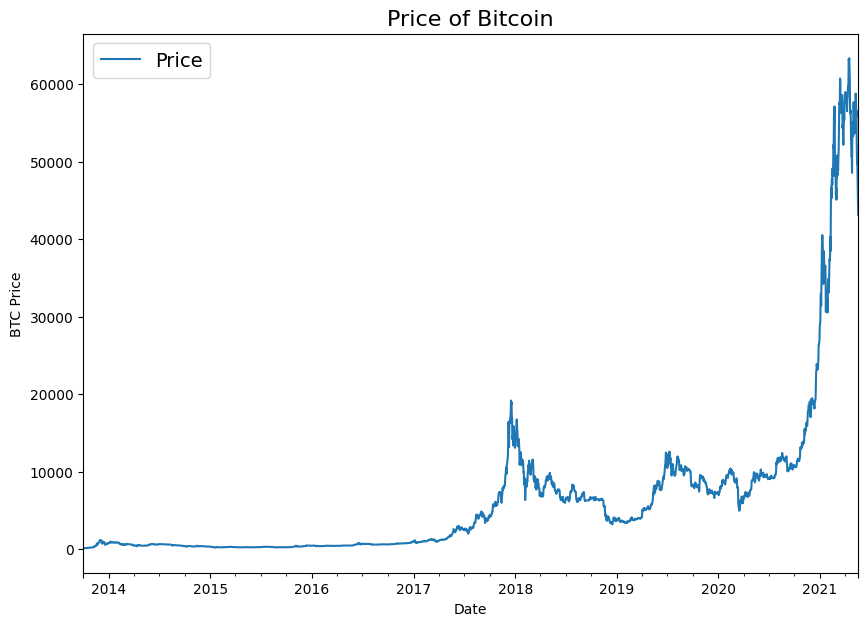

In [15]:
bitcoin_prices_df.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin', fontsize=16)
plt.legend(fontsize=14, loc='upper left')

## (Optional) Get time series data with Python's CSV module

In [16]:
# import csv
# from datetime import datetime

# timesteps = []
# btc_prices = []
# with open(bitcoin_csv, 'r') as f:
#     csv_reader = csv.reader(f, delimiter=',')
#     next(csv_reader) # skip the first line
#     for line in csv_reader:
#         timesteps.append(datetime.strptime(line[1], '%Y-%m-%d'))
#         btc_prices.append(float(line[2]))

In [17]:
# plt.figure(figsize=(10, 7))
# plt.plot(timesteps, btc_prices)
# plt.xlabel('Date')
# plt.ylabel('BTC Price')
# plt.title('Price of Bitcoin', fontsize=16)

## Split the data

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(
    timesteps,
    prices,
    train_size=0.8,
    shuffle=False
)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2229,), (558,), (2229,), (558,))

In [19]:
# split = int(0.8 * len(timesteps))
# train_features, train_labels = timesteps[:split], prices[:split]
# test_features, test_labels = timesteps[split:], prices[split:]

# len(train_features), len(test_features), len(train_labels), len(test_labels)

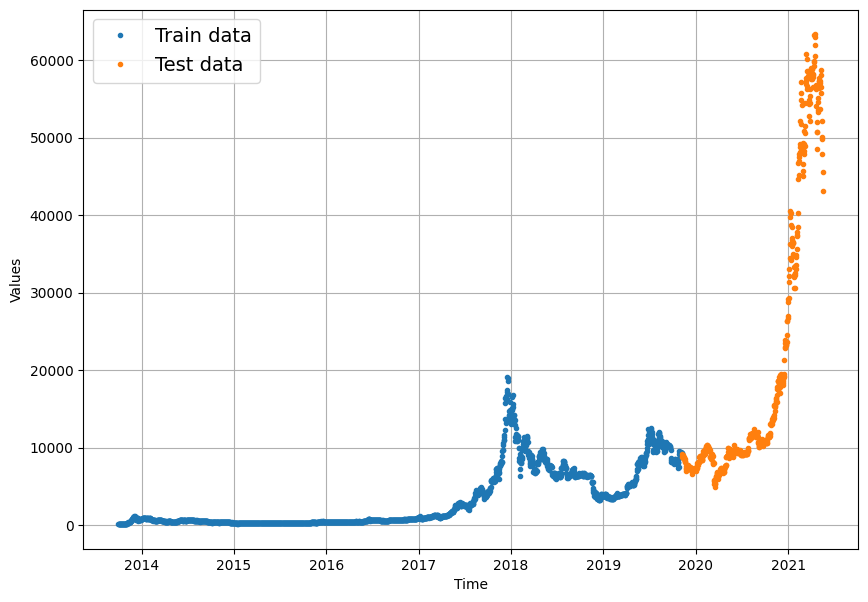

In [20]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=Y_train, label="Train data")
plot_time_series(timesteps=X_test, values=Y_test, label="Test data")

## Naïve Forecast (baseline model)

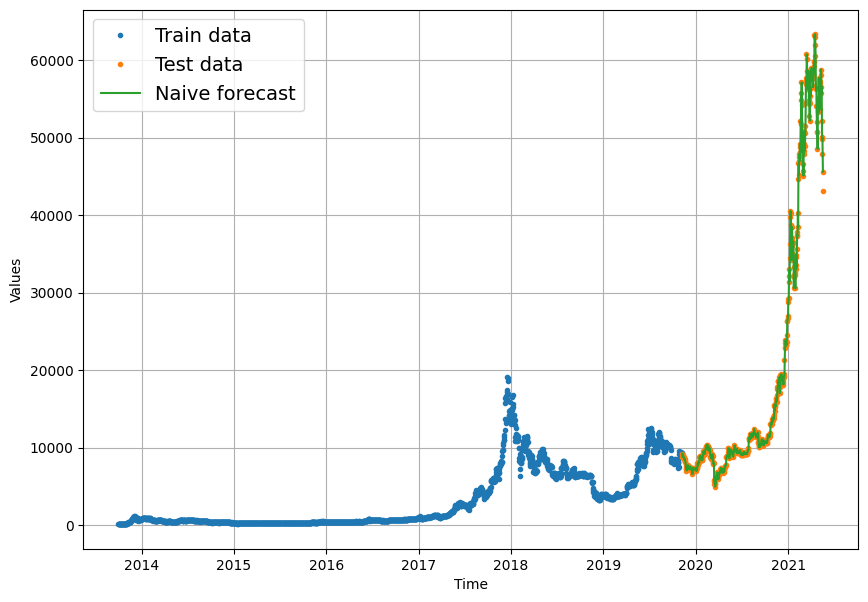

In [21]:
# Create a naïve forecast
naive_forecast = Y_test[:-1] # Naïve forecast equals every value excluding the last value

# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=Y_train, label="Train data")
plot_time_series(timesteps=X_test, values=Y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast")

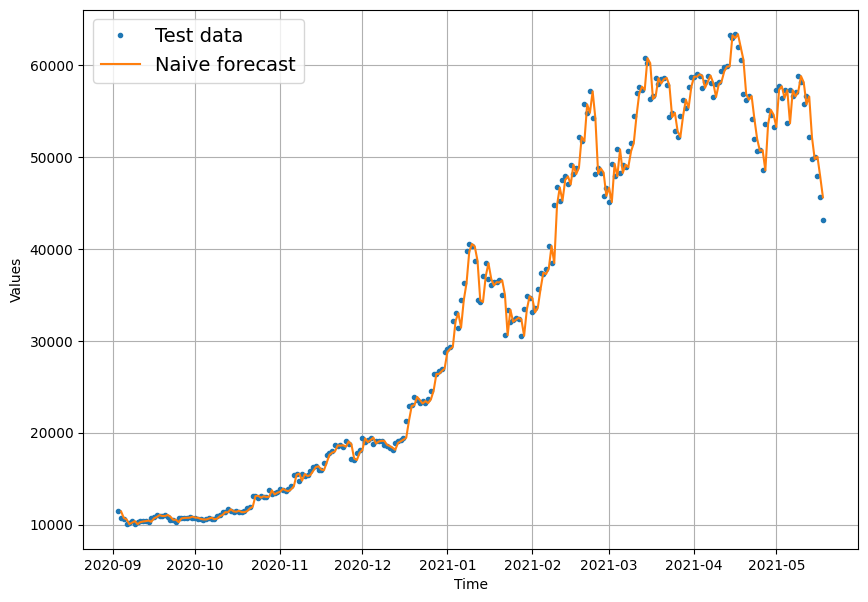

In [22]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=Y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast")

In [23]:
naive_results = evaluate_preds(y_true=Y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Dense Model (Windows = 7 and Horizons = 1)

In [38]:
WINDOW_SIZE = 7
HORIZON = 1

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Review the windows and labels after formating data into windows
# for i in range(3):
#     print(f"{full_windows[i-3]} -> {full_labels[i-3]}")

In [39]:
train_windows, test_windows, train_labels, test_labels = train_test_split(
    full_windows,
    full_labels,
    train_size=0.8,
    shuffle=False
)

train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [40]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON) # number of horizons
], name='dense_model_w7h1')

dense_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MAE,
    metrics=['mae']
)

dense_model.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=dense_model.name)] # save best
)

INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w7h1\assets

In [41]:
dense_model = tf.keras.models.load_model('model_experiments/dense_model_w7h1/')
dense_model.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 565.5773 - mae: 565.5773


[565.5773315429688, 565.5773315429688]

In [28]:
dense_model_preds = make_preds(dense_model, input_data=test_windows)
dense_model_results = evaluate_preds(tf.squeeze(test_labels), dense_model_preds)
dense_model_results

18/18 [==============================] - 0s 2ms/step


{'mae': 605.5936,
 'mape': 2.7708173,
 'mase': 1.0585836,
 'mse': 1258209.6,
 'rmse': 1121.6995}

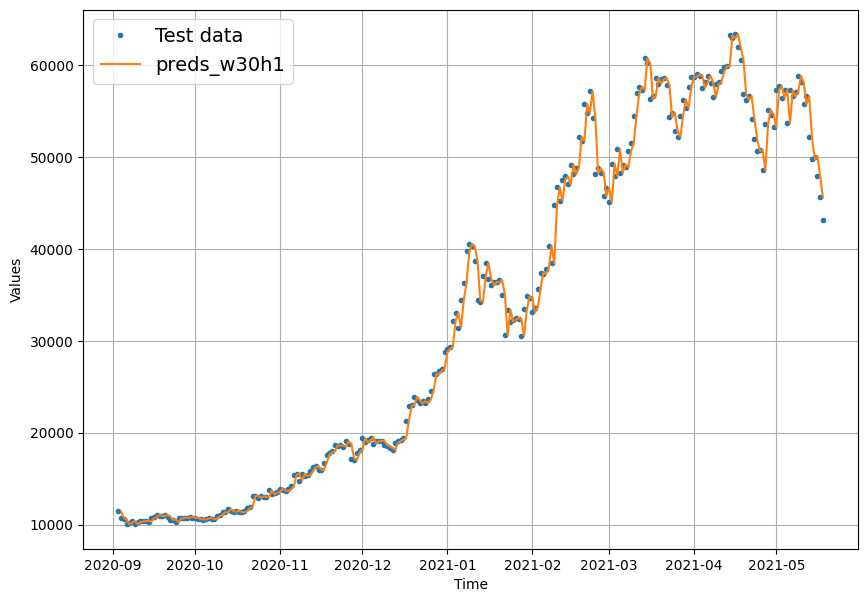

In [30]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=Y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="dense_preds_w30h1")

## Dense Model (Windows = 30 and Horizons = 7)

In [31]:
WINDOW_SIZE = 30
HORIZON = 7

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [32]:
train_windows, test_windows, train_labels, test_labels = train_test_split(
    full_windows,
    full_labels,
    train_size=0.8,
    shuffle=False
)

train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2200, 30), (551, 30), (2200, 7), (551, 7))

In [33]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON) # number of horizons
], name='dense_model_w30h7')

dense_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MAE,
    metrics=['mae']
)

dense_model.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=dense_model.name)] # save best
)

INFO:tensorflow:Assets written to: model_experiments\dense_model_w30h7\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w30h7\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w30h7\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w30h7\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w30h7\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w30h7\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w30h7\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w30h7\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w30h7\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w30h7\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w30h7\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_w30h7\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model

In [34]:
dense_model = tf.keras.models.load_model('model_experiments/dense_model_w30h7/')
dense_model.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1231.2809 - mae: 1231.2809


[1231.2808837890625, 1231.2808837890625]

In [35]:
dense_model_preds = make_preds(dense_model, input_data=test_windows)
dense_model_results = evaluate_preds(tf.squeeze(test_labels), dense_model_preds)
dense_model_results

18/18 [==============================] - 0s 1ms/step


{'mae': 1231.2808,
 'mape': 5.499911,
 'mase': 2.1909955,
 'mse': 5294076.5,
 'rmse': 1418.6771}

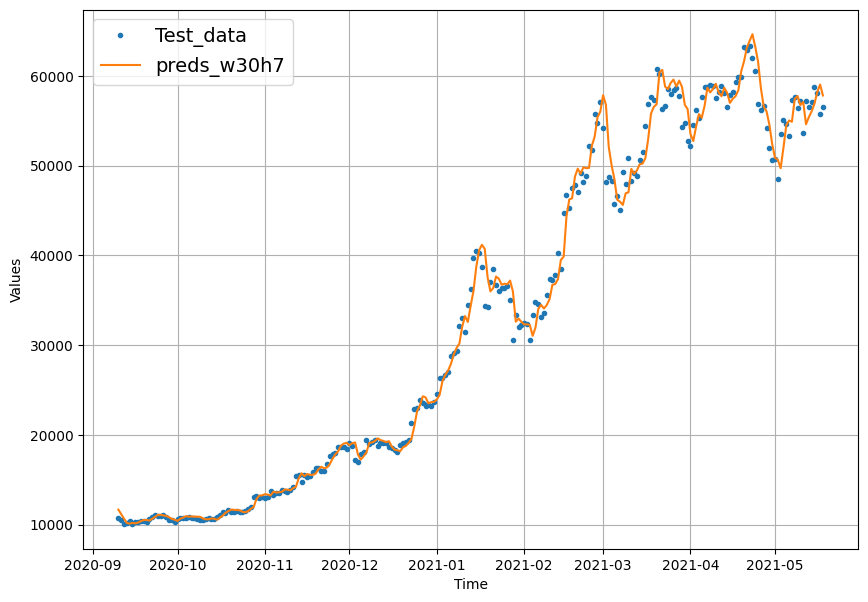

In [36]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(dense_model_preds, axis=1), # reduce to mean of multi-dimension
                 format="-",
                 start=offset, 
                 label="dense_preds_w30h7")

## Conv1D Model (Windows = 7 and Horizons = 1)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dims)`

In [19]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
# x = tf.constant(train_windows[0])
# expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps

In [20]:
WINDOW_SIZE = 7
HORIZON = 1

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [21]:
train_windows, test_windows, train_labels, test_labels = train_test_split(
    full_windows,
    full_labels,
    train_size=0.8,
    shuffle=False
)

train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [22]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

conv1d_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # add an extra dimension for timesteps
    tf.keras.layers.Conv1D(128, 5, padding='causal', activation='relu'),
    tf.keras.layers.Dense(HORIZON)
], name='conv1d_model_w7h1')

conv1d_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MAE,
    metrics=['mae']
)

conv1d_model.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=conv1d_model.name)] # save best
)

INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\conv1d_model_w7h1\assets


In [23]:
conv1d_model = tf.keras.models.load_model('model_experiments/conv1d_model_w7h1/')
conv1d_model.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 9ms/step - loss: 568.8171 - mae: 568.8171


[568.817138671875, 568.817138671875]

In [27]:
conv1d_model_preds = make_preds(conv1d_model, input_data=test_windows)
conv1d_model_results = evaluate_preds(tf.squeeze(test_labels), conv1d_model_preds)
conv1d_model_results

18/18 [==============================] - 0s 3ms/step


{'mae': 568.81714,
 'mape': 2.5557487,
 'mase': 0.99925417,
 'mse': 1177626.8,
 'rmse': 1085.185}

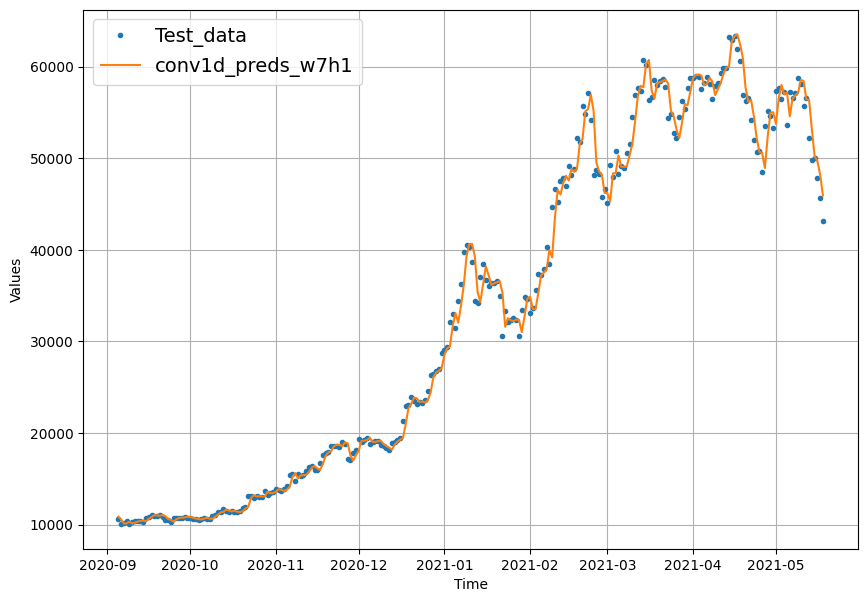

In [29]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=conv1d_model_preds,
                 format="-",
                 start=offset, 
                 label="conv1d_preds_w7h1")

## LSTM Model (Windows = 7 and Horizons = 1)

To use the LSTM layer, we need an input shape of: `(batch_size, timesteps, feature)`

In [30]:
WINDOW_SIZE = 7
HORIZON = 1

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [31]:
train_windows, test_windows, train_labels, test_labels = train_test_split(
    full_windows,
    full_labels,
    train_size=0.8,
    shuffle=False
)

train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [33]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

# Let's build an LSTM model with the Functional API
inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = tf.keras.layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = tf.keras.layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(HORIZON)(x)
lstm_model = tf.keras.Model(inputs=inputs, outputs=output, name="lstm_model_w7h1")

# Compile model
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MAE
)

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
lstm_model.fit(
    train_windows,
    train_labels,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=lstm_model.name)]
)

INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


INFO:tensorflow:Assets written to: model_experiments\lstm_model_w7h1\assets


In [34]:
lstm_model = tf.keras.models.load_model('model_experiments/lstm_model_w7h1/')
lstm_model.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 9ms/step - loss: 597.7114


597.7113647460938

In [35]:
lstm_model_preds = make_preds(lstm_model, input_data=test_windows)
lstm_model_results = evaluate_preds(tf.squeeze(test_labels), lstm_model_preds)
lstm_model_results

18/18 [==============================] - 0s 2ms/step


{'mae': 597.71136,
 'mape': 2.674492,
 'mase': 1.0500133,
 'mse': 1273302.9,
 'rmse': 1128.4072}

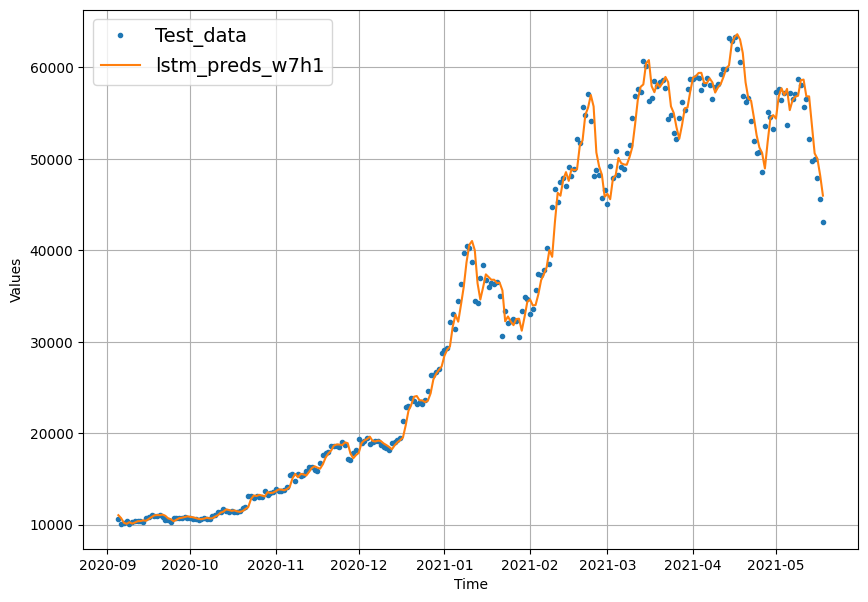

In [36]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=lstm_model_preds,
                 format="-",
                 start=offset, 
                 label="lstm_preds_w7h1")

## \* Adding extra feature (Bitcoin Block Reward) to make data multivariate

<Axes: xlabel='Date'>

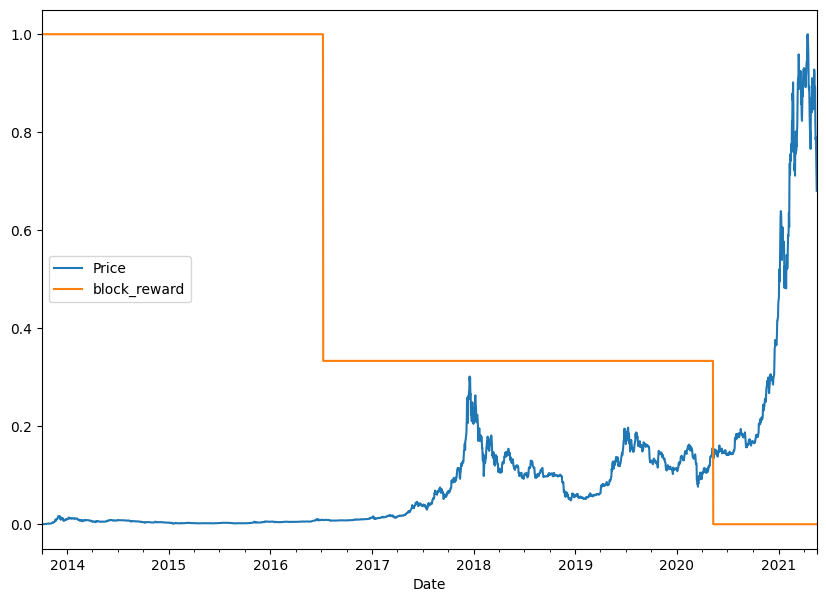

In [42]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices_df.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices_df.index[0]).days
block_reward_2_days, block_reward_3_days

# Add block_reward column
bitcoin_prices_block = bitcoin_prices_df.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

In [43]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

## Dense Model (multivariate time series)

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    shuffle=False
)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2224, 8), (556, 8), (2224,), (556,))

In [27]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

# Make multivariate time series model
dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
    tf.keras.layers.Dense(HORIZON)
], name="dense_model_multivariate")

# Compile
dense_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MAE
)

# Fit
dense_model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=128,
    verbose=0, # only print 1 line per epoch
    validation_data=(X_test, Y_test),
    callbacks=[create_model_checkpoint(model_name=dense_model.name)]
)

INFO:tensorflow:Assets written to: model_experiments\dense_model_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_multivariate\assets
INFO:tensorflow:Assets written to: model_experiments\dense_model_

In [28]:
# Make sure best model is loaded and evaluate
dense_model = tf.keras.models.load_model("model_experiments/dense_model_multivariate")
dense_model.evaluate(X_test, Y_test)

18/18 [==============================] - 0s 3ms/step - loss: 569.2559


569.2559204101562

In [36]:
# Make predictions on multivariate data
dense_model_preds = tf.squeeze(dense_model.predict(X_test))
# Evaluate preds
dense_model_results = evaluate_preds(y_true=Y_test, y_pred=dense_model_preds)
dense_model_results

18/18 [==============================] - 0s 2ms/step


{'mae': 569.25586,
 'mape': 2.5502262,
 'mase': 1.0000249,
 'mse': 1183401.9,
 'rmse': 1087.8428}

## N-BEATS Model

### Create N-BEATS-Block class

Based on N-BEATS algorithm - [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

In [24]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

### Prepare dataset

In [23]:
WINDOW_SIZE = 7
HORIZON = 1

# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices_df.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)

# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [24]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [25]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [26]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
nbeats_model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
nbeats_model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
nbeats_model.fit(train_dataset,
                 epochs=N_EPOCHS,
                 validation_data=test_dataset,
                 verbose=0, # prevent large amounts of training outputs
                 # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 222: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 322: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [27]:
# Evaluate N-BEATS model on the test dataset
nbeats_model.evaluate(test_dataset)

1/1 [==============================] - 0s 81ms/step - loss: 588.9324 - mae: 588.9324 - mse: 1232981.6250


[588.932373046875, 588.932373046875, 1232981.625]

In [31]:
# Make predictions with N-BEATS model
nbeats_model_preds = make_preds(nbeats_model, test_dataset)
# Evaluate N-BEATS model predictions
nbeats_model_results = evaluate_preds(y_true=y_test,
                                 y_pred=nbeats_model_preds)
nbeats_model_results

1/1 [==============================] - 0s 35ms/step


{'mae': 588.9324,
 'mape': 2.6750135,
 'mase': 1.0345911,
 'mse': 1232981.6,
 'rmse': 1110.397}

In [33]:
# from tensorflow.keras.utils import plot_model
# plot_model(nbeats_model)

## Ensemble Models

In [25]:
WINDOW_SIZE = 7
HORIZON = 1

In [26]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        tf.keras.layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [27]:
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 441: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 755: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 855: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 381: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 481: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 282: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 752: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 854: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 954: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 536:

In [28]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [29]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

1/1 [==============================] - 0s 45ms/step


{'mae': 567.5223,
 'mape': 2.5448275,
 'mase': 0.9969795,
 'mse': 1145081.6,
 'rmse': 1070.0848}

### Plotting the prediction intervals (uncertainty estimates)

In [30]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

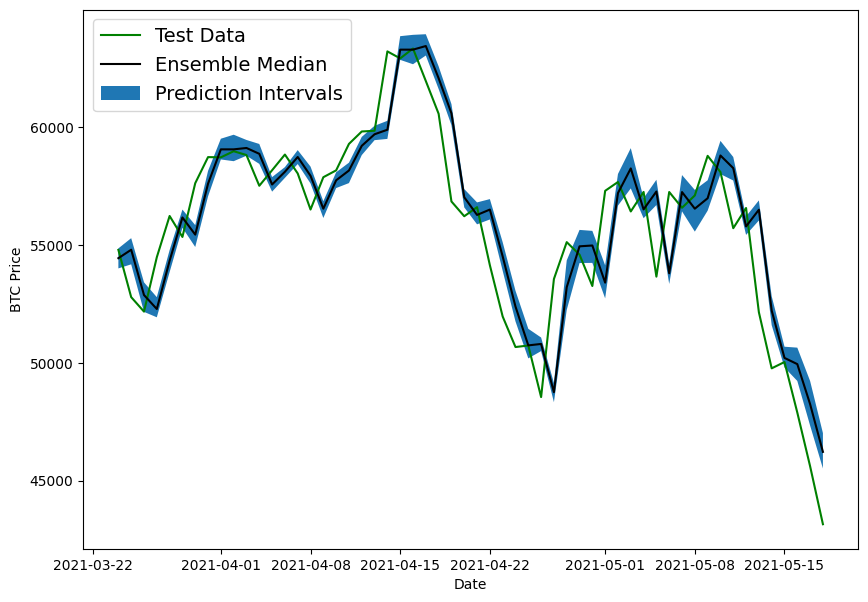

In [31]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

## True Future Model

In [21]:
HORIZON = 1
WINDOW_SIZE = 7

In [25]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [26]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

# Create model (nice and simple, just to test)
true_future_model = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(HORIZON)
], name="true_future_model")

# Compile
true_future_model.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
true_future_model.fit(dataset_all,
                      epochs=100,
                      verbose=0,
                      #callbacks=[create_model_checkpoint(model_name=true_future_model.name)] # warnings with no validation data
)

### Make predictions on the future

In [26]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

In [27]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [28]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=true_future_model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 84ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55574.69140625

1/1 [==============================] - 0s 29ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55574.69140625] -> Prediction: 50167.09375

1/1 [==============================] - 0s 25ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55574.69140625 50167.09375   ] -> Prediction: 50040.8828125

1/1 [==============================] - 0s 20ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55574.69140625 50167.09375    50040.8828125 ] -> Prediction: 49404.328125

1/1 [==============================] - 0s 21ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55574.69140625
 50167.09375    50040.8828125  49404.328125 

In [29]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

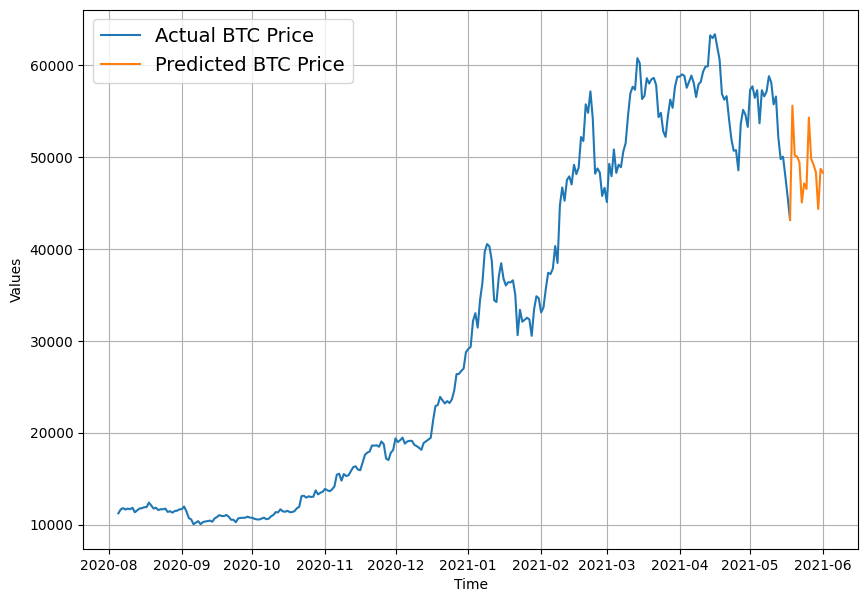

In [30]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices_df.index[-1]

# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)

# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])

# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices_df.index, prices, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Turkey Problem Model

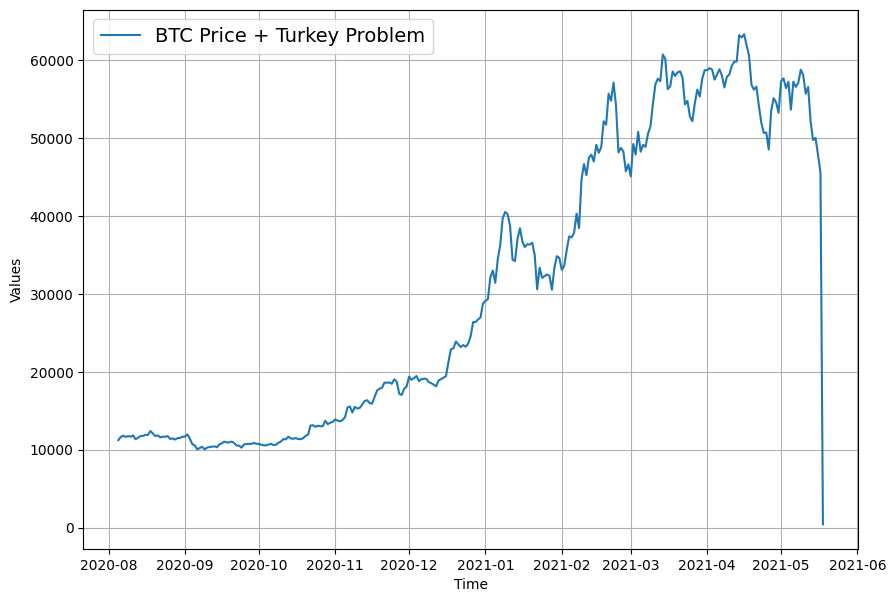

In [44]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

# Get the timesteps for the turkey problem 
btc_timesteps_turkey = np.array(bitcoin_prices_df.index)

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, values=btc_price_turkey, format="-", label="BTC Price + Turkey Problem", start=2500)

In [45]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = train_test_split(
    full_windows,
    full_labels,
    train_size=0.8,
    shuffle=False
)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [46]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(dense_model)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiments\Turkey_Model\assets
INFO:tensorflow:Assets written to: model_experiment

In [47]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 637.9242


637.9241943359375

In [48]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

18/18 [==============================] - 0s 2ms/step


{'mae': 17133.777,
 'mape': 121.422646,
 'mase': 26.514576,
 'mse': 614619000.0,
 'rmse': 23719.736}